# Advanced Dimensionality Reduction Comparison (Modular)
This notebook evaluates various feature extraction and dimensionality reduction techniques for alpha generation.

### Fixed issues:
- **NMF**: Added explicit clipping to prevent tiny floating-point negatives.
- **KernelPCA**: Using **Nystroem Approximation** for large-scale non-linear mapping.
- **Modular Cells**: Each technique is in its own cell for granular control.

In [ ]:
!pip install umap-learn --quiet


In [23]:
import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from bokeh.io import output_notebook, show

try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False

output_notebook()

if os.getcwd().endswith('notebooks'):
    os.chdir('..')
ROOT = os.getcwd()
if ROOT not in sys.path: sys.path.insert(0, ROOT)

from src.backtester.data import align_close_prices, load_cleaned_assets
from src.backtester.engine import BacktestConfig, run_backtest
from src.backtester.report import compute_backtest_report
from src.backtester.bokeh_plots import build_interactive_portfolio_layout

FEATURES_PARQUET_PATH = 'dataset/features/all_features.parquet'
TARGET_COL = 'ret_1d'
TARGET_FWD_COL = 'y_ret_1d_fwd'
SEED = 42

all_reports = {}
equities = {}

Loading BokehJS ...

## 1) Data Loading & Bucketing

In [24]:
df = pd.read_parquet(FEATURES_PARQUET_PATH)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

df[TARGET_FWD_COL] = df.groupby('Asset_ID', sort=False)[TARGET_COL].shift(-1)
df = df.dropna(subset=[TARGET_FWD_COL])

buckets = {
    'Volume': [
        'log_volume', 'volume_roll_mean_5', 'volume_roll_mean_20', 'volume_roll_mean_60', 
        'volume_roll_std_5', 'volume_roll_std_20', 'volume_roll_std_60', 
        'volume_zscore_5', 'volume_zscore_20', 'volume_zscore_60', 
        'volume_minmax_20', 'obv', 'obv_roc_10', 'wrobv_20', 'ad_line'
    ],
    'Volatility': [
        'logret_roll_var_5', 'logret_roll_var_10', 'logret_roll_var_20', 'logret_roll_var_60', 
        'logret_roll_std_5', 'logret_roll_std_10', 'logret_roll_std_20', 'logret_roll_std_60', 
        'atr_14', 'realized_vol_20', 'bb_bb_bandwidth'
    ],
    'Trend': [
        'sma_20', 'sma_50', 'ha_ha_open', 'ha_ha_high', 'ha_ha_low', 'ha_ha_close', 
        'sma_ratio_20', 'ema_ratio_20', 'bb_bb_mid', 'bb_bb_upper', 'bb_bb_lower', 
        'bb_bb_percent_b', 'adx_plus_di', 'adx_minus_di', 'adx_adx', 'adx_adx_raw', 
        'aroon_aroon_up', 'aroon_aroon_down', 'ichimoku_ichimoku_conv', 
        'ichimoku_ichimoku_base', 'ichimoku_ichimoku_span_a', 'ichimoku_ichimoku_span_b', 
        'ichimoku_ichimoku_lagging', 'bos', 'choch', 'mss'
    ],
    'Momentum': [
        'rsi_14', 'macd_macd', 'macd_macd_signal', 'macd_macd_hist', 
        'rmacd_12_26_9', 'stoch_stoch_k', 'stoch_stoch_d', 'roc_10', 'cci_20'
    ]
}

for b in buckets: buckets[b] = [c for c in buckets[b] if c in df.columns]

cutoff = '2023-01-01'
df_train = df[df.index < cutoff].copy()
df_test = df[df.index >= cutoff].copy()

print(f'Train/Test rows: {len(df_train)} / {len(df_test)}')

Train/Test rows: 174800 / 76200


## 2) Technique Framework

In [25]:
def run_dim_reduction_pipeline(method_name, reducer_obj):
    print(f'\n--- Running {method_name} ---')
    tr_feats, te_feats = [], []
    for b_name, cols in buckets.items():
        X_tr = df_train[cols].replace([np.inf, -np.inf], np.nan).fillna(0)
        X_te = df_test[cols].replace([np.inf, -np.inf], np.nan).fillna(0)
        scaler = MinMaxScaler() if method_name == 'NMF' else StandardScaler()
        steps = [('imputer', SimpleImputer(strategy='median')), ('scaler', scaler)]
        if method_name == 'NMF':
            steps.append(('clipper', FunctionTransformer(lambda x: np.clip(x, 1e-9, None))))
        steps.append(('reducer', reducer_obj))
        pipe = Pipeline(steps)
        if method_name == 'LDA':
            pipe.fit(X_tr, np.sign(df_train[TARGET_FWD_COL]))
        else:
            pipe.fit(X_tr)
        tr_feats.append(pipe.transform(X_tr))
        te_feats.append(pipe.transform(X_te))
    X_tr_stacked = np.hstack(tr_feats)
    X_te_stacked = np.hstack(te_feats)
    rf = RandomForestRegressor(n_estimators=100, max_depth=8, n_jobs=-1, random_state=SEED)
    rf.fit(X_tr_stacked, df_train[TARGET_FWD_COL])
    preds = rf.predict(X_te_stacked)
    test_syms = df_test['Asset_ID'].unique()
    close_prices = align_close_prices(load_cleaned_assets(symbols=test_syms))
    df_out = df_test.copy(); df_out['y_pred'] = preds
    w = df_out.pivot(columns='Asset_ID', values='y_pred').reindex(close_prices.index).fillna(0)
    w_rank = w.rank(axis=1, ascending=False)
    w_final = ((w_rank <= 5) & (w > 0)).astype(float)
    w_final = w_final.div(w_final.sum(axis=1), axis=0).fillna(0)
    res = run_backtest(close_prices, w_final, BacktestConfig(rebalance='D'))
    report = compute_backtest_report(result=res, close_prices=close_prices)
    
    # PRINT FULL REPORT
    print(f'\n--- {method_name} Detailed Report ---')
    print(report)
    
    # SHOW BOKEH PLOT
    try:
        # Create a proxy market OHLCV for visualization
        mkt = pd.DataFrame(index=close_prices.index)
        mkt['Close'] = close_prices.iloc[:, 0]
        mkt['Open'] = mkt['Close']; mkt['High'] = mkt['Close']; mkt['Low'] = mkt['Close']; mkt['Volume'] = 0
        
        p = build_interactive_portfolio_layout(
            market_ohlcv=mkt, 
            equity=res.equity,
            returns=res.returns,
            weights=res.weights,
            turnover=res.turnover,
            costs=res.costs,
            title=f"{method_name} Backtest Analysis"
        )
        show(p)
    except Exception as e:
        print(f'Bokeh plot failed for {method_name}: {e}')
        
    return report, res.equity

## 3) Methods Execution (Fast Methods)

In [26]:
fast_methods = {
    'ICA': FastICA(n_components=2, random_state=SEED),
    'LDA': LinearDiscriminantAnalysis(n_components=1),
    'SVD': TruncatedSVD(n_components=2, random_state=SEED),
    'NMF': NMF(n_components=2, random_state=SEED, init='nndsvd', max_iter=1000)
}
for name, obj in fast_methods.items():
    rep, eq = run_dim_reduction_pipeline(name, obj)
    all_reports[name], equities[name] = rep, eq
    print(f'{name} CAGR: {rep["CAGR [%]"]:.2f}%')


--- Running ICA ---

--- ICA Detailed Report ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                           999500.0
Final Equity                        2049173.70531
Equity Peak                        2144827.764263
Total Return [%]                        105.01988
CAGR [%]                                26.798358
Volatility (ann) [%]                    27.470266
Sharpe                                   0.999511
Sortino                                   1.65259
Max Drawdown [%]                       -27.489511
Calmar                                   0.974858
Best Day [%]                            16.116582
Worst Day [%]                           -7.967022
Avg Gross Exposure                        0.99909
Avg Net Exposure                          0.99909
Exposure Time [%]                       99.868938
Rebalance Days                                763


ICA CAGR: 26.80%

--- Running LDA ---

--- LDA Detailed Report ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                           999500.0
Final Equity                       1421220.834308
Equity Peak                        1494934.910473
Total Return [%]                         42.19318
CAGR [%]                                12.346186
Volatility (ann) [%]                    22.917871
Sharpe                                   0.620082
Sortino                                  1.082296
Max Drawdown [%]                       -20.156508
Calmar                                   0.612516
Best Day [%]                            14.739051
Worst Day [%]                           -8.994781
Avg Gross Exposure                       0.999378
Avg Net Exposure                         0.999378
Exposure Time [%]                       99.868938
Rebalance Days                   

LDA CAGR: 12.35%

--- Running SVD ---

--- SVD Detailed Report ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                           999500.0
Final Equity                       1851947.513294
Equity Peak                        1968486.970031
Total Return [%]                        85.287395
CAGR [%]                                 22.62498
Volatility (ann) [%]                    26.553381
Sharpe                                   0.898677
Sortino                                  1.514845
Max Drawdown [%]                       -24.348286
Calmar                                   0.929223
Best Day [%]                            15.889045
Worst Day [%]                           -9.696805
Avg Gross Exposure                       0.999064
Avg Net Exposure                         0.999064
Exposure Time [%]                       99.868938
Rebalance Days                   

SVD CAGR: 22.62%

--- Running NMF ---


/home/anivarth/college/quant-task/.venv_uv/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1720: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(



--- NMF Detailed Report ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                           999500.0
Final Equity                       2055876.266266
Equity Peak                        2148747.132721
Total Return [%]                       105.690472
CAGR [%]                                26.935366
Volatility (ann) [%]                    28.076136
Sharpe                                   0.987646
Sortino                                  1.643141
Max Drawdown [%]                       -28.548289
Calmar                                   0.943502
Best Day [%]                            16.439405
Worst Day [%]                           -8.207102
Avg Gross Exposure                       0.999105
Avg Net Exposure                         0.999105
Exposure Time [%]                       99.868938
Rebalance Days                                763
Total Turnover       

NMF CAGR: 26.94%


## 3.1) Factor Analysis (FA) - Slow

In [ ]:
name = 'FA'
obj = FactorAnalysis(n_components=2, random_state=SEED)
rep, eq = run_dim_reduction_pipeline(name, obj)
all_reports[name], equities[name] = rep, eq
print(f'{name} CAGR: {rep["CAGR [%]"]:.2f}%')

## 3.2) Kernel PCA Approximation (Nystroem)

In [27]:
name = 'KernelPCA_Approx'
obj = Pipeline([
    ('nystroem', Nystroem(kernel='poly', degree=2, n_components=100, random_state=SEED)),
    ('pca', PCA(n_components=2))
])
rep, eq = run_dim_reduction_pipeline(name, obj)
all_reports[name], equities[name] = rep, eq
print(f'{name} CAGR: {rep["CAGR [%]"]:.2f}%')


--- Running KernelPCA_Approx ---

--- KernelPCA_Approx Detailed Report ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                           999500.0
Final Equity                       2497625.985664
Equity Peak                        2604653.277231
Total Return [%]                       149.887542
CAGR [%]                                35.374725
Volatility (ann) [%]                    27.114425
Sharpe                                   1.250207
Sortino                                  2.154106
Max Drawdown [%]                        -21.02126
Calmar                                   1.682807
Best Day [%]                            14.881038
Worst Day [%]                           -7.275235
Avg Gross Exposure                       0.999064
Avg Net Exposure                         0.999064
Exposure Time [%]                       99.868938
Rebalance Days          

KernelPCA_Approx CAGR: 35.37%


## 3.3) UMAP

In [28]:
if HAS_UMAP:
    name = 'UMAP'
    obj = umap.UMAP(n_components=2, random_state=SEED)
    rep, eq = run_dim_reduction_pipeline(name, obj)
    all_reports[name], equities[name] = rep, eq
    print(f'{name} CAGR: {rep["CAGR [%]"]:.2f}%')
else:
    print('UMAP not found. Skipping...')

UMAP not found. Skipping...


## 3.4) Autoencoder

In [29]:
import torch; import torch.nn as nn; import torch.optim as optim
class SimpleAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 16), nn.ReLU(), nn.Linear(16, hidden_dim))
        self.decoder = nn.Sequential(nn.Linear(hidden_dim, 16), nn.ReLU(), nn.Linear(16, input_dim))
    def forward(self, x): return self.decoder(self.encoder(x))
ae_tr_list, ae_te_list = [], []
for _, cols in buckets.items():
    X_tr_raw = df_train[cols].replace([np.inf, -np.inf], np.nan)
    X_te_raw = df_test[cols].replace([np.inf, -np.inf], np.nan)
    X_tr = SimpleImputer(strategy='median').fit_transform(X_tr_raw)
    scaler = StandardScaler().fit(X_tr)
    X_tr_s = torch.FloatTensor(scaler.transform(X_tr))
    X_te = SimpleImputer(strategy='median').fit_transform(X_te_raw)
    X_te_s = torch.FloatTensor(scaler.transform(X_te))
    model = SimpleAE(X_tr.shape[1])
    opt = optim.Adam(model.parameters(), lr=0.01); crit = nn.MSELoss()
    for _ in range(10): opt.zero_grad(); l = crit(model(X_tr_s), X_tr_s); l.backward(); opt.step()
    model.eval()
    with torch.no_grad(): ae_tr_list.append(model.encoder(X_tr_s).numpy()); ae_te_list.append(model.encoder(X_te_s).numpy())
X_ae_tr, X_ae_te = np.hstack(ae_tr_list), np.hstack(ae_te_list)
rf_ae = RandomForestRegressor(n_estimators=100, max_depth=8, n_jobs=-1, random_state=SEED)
rf_ae.fit(X_ae_tr, df_train[TARGET_FWD_COL]); preds = rf_ae.predict(X_ae_te)
df_ae = df_test.copy(); df_ae['y_pred'] = preds
cp = align_close_prices(load_cleaned_assets(symbols=df_test['Asset_ID'].unique()))
w = df_ae.pivot(columns='Asset_ID', values='y_pred').reindex(cp.index).fillna(0)
w_final = (w.rank(axis=1, ascending=False) <= 5) & (w > 0)
w_final = w_final.astype(float).div(w_final.sum(axis=1), axis=0).fillna(0)
res = run_backtest(cp, w_final, BacktestConfig())
rep = compute_backtest_report(result=res, close_prices=cp)
all_reports['Autoencoder'], equities['Autoencoder'] = rep, res.equity
print(f'\n--- Autoencoder Detailed Report ---')
print(rep)
try:
    mkt = pd.DataFrame(index=cp.index)
    mkt['Close'] = cp.iloc[:, 0]
    mkt['Open'] = mkt['Close']; mkt['High'] = mkt['Close']; mkt['Low'] = mkt['Close']; mkt['Volume'] = 0
    p = build_interactive_portfolio_layout(market_ohlcv=mkt, equity=res.equity, returns=res.returns, weights=res.weights, turnover=res.turnover, costs=res.costs, title="Autoencoder Backtest Analysis")
    show(p)
except Exception as e: print(f"Plot fail: {e}")
print(f'Autoencoder CAGR: {rep["CAGR [%]"]:.2f}%')


--- Autoencoder Detailed Report ---
Start                         2023-01-03 00:00:00
End                           2026-01-16 00:00:00
Duration                       1109 days 00:00:00
Initial Equity                           999500.0
Final Equity                        1816623.55704
Equity Peak                        1909202.330694
Total Return [%]                        81.753232
CAGR [%]                                21.846481
Volatility (ann) [%]                    25.827345
Sharpe                                    0.89041
Sortino                                  1.569124
Max Drawdown [%]                       -28.033312
Calmar                                   0.779304
Best Day [%]                            19.688328
Worst Day [%]                           -8.617046
Avg Gross Exposure                       0.999141
Avg Net Exposure                         0.999141
Exposure Time [%]                       99.868938
Rebalance Days                                763
Total Turnove

Autoencoder CAGR: 21.85%


## 4) Summary Comparison

,CAGR [%],Sharpe,Max Drawdown [%],Volatility (ann) [%]
ICA,26.798358,0.999511,-27.489511,27.470266
LDA,12.346186,0.620082,-20.156508,22.917871
SVD,22.62498,0.898677,-24.348286,26.553381
NMF,26.935366,0.987646,-28.548289,28.076136
KernelPCA_Approx,35.374725,1.250207,-21.02126,27.114425
Autoencoder,21.846481,0.89041,-28.033312,25.827345


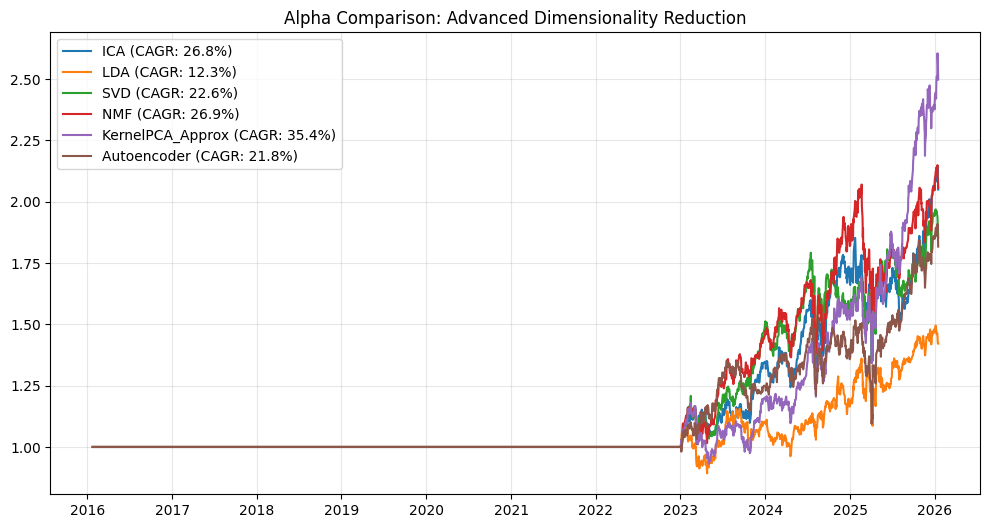

In [30]:
comp_df = pd.DataFrame(all_reports).T[['CAGR [%]', 'Sharpe', 'Max Drawdown [%]', 'Volatility (ann) [%]']]
display(comp_df)
plt.figure(figsize=(12, 6))
for name, eq in equities.items():
    plt.plot(eq / eq.iloc[0], label=f'{name} (CAGR: {comp_df.loc[name, "CAGR [%]"]:.1f}%)')
plt.title('Alpha Comparison: Advanced Dimensionality Reduction'); plt.legend(); plt.grid(True, alpha=0.3); plt.show()